In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# load dataset
df = pd.read_csv("../data/raw_data.csv")

In [3]:
# keep required columns
columns= ['bedrooms','bathrooms','floors', 'waterfront','view', 'condition', 'yr_renovated', 'yr_built', 'sqft_lot', 'sqft_living','sqft_basement', 'city', 'price' ]
df = df[columns]

In [4]:
# drop rows that has zero in price or #bathrooms, #bedrooms
df = df[(df['price'] != 0) & (df['bathrooms'] != 0) & (df['bedrooms'] != 0)]

In [5]:
# column transformation
df.insert(df.columns.get_loc('yr_built'), 'age', 2025 - df['yr_built'])
df.insert(df.columns.get_loc('yr_renovated'), 'was_renovated',
          np.where(df['yr_renovated'] > 0, 1, 0))
df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

In [6]:
# apply log transform
skewed = ['price', 'sqft_lot', 'sqft_living','sqft_basement']
df[skewed] = np.log1p(df[skewed])

In [7]:
# clip the top and bottom
for col in ['sqft_lot', 'view']:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)

In [8]:
# feature selection
X = df.iloc[:, 0:-1]
y = df.iloc[:,-1]

In [9]:
# encoding categorical Data (city)
ct = ColumnTransformer(transformers=[('city_encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ['city'])], remainder='passthrough')
X_transformed = np.array(ct.fit_transform(X))
print(X_transformed, X_transformed.shape, X_transformed.dtype)

[[0.         0.         0.         ... 8.97626226 7.20117088 0.        ]
 [0.         0.         0.         ... 9.11063053 8.20275638 5.63835467]
 [0.         0.         0.         ... 9.38831918 7.56579328 0.        ]
 ...
 [0.         0.         0.         ... 8.22977775 7.65491705 0.        ]
 [0.         0.         0.         ... 8.37424618 7.67368813 6.85751406]
 [0.         0.         0.         ... 9.27387839 8.58316818 7.37838371]] (4383, 54) float64


In [10]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y,test_size=0.2, random_state=42, shuffle=True)

In [21]:
# save everything in one .npz file
np.savez(
    "../data/tree_processed_data.npz",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [11]:
X_train

array([[0.        , 0.        , 0.        , ..., 7.38956395, 7.43307535,
        6.29341928],
       [0.        , 0.        , 0.        , ..., 9.03610603, 7.56579328,
        6.80350526],
       [0.        , 0.        , 0.        , ..., 8.85723049, 8.15794351,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 9.31479047, 6.76964198,
        0.        ],
       [0.        , 0.        , 0.        , ..., 8.7524234 , 7.66434663,
        6.53813982],
       [0.        , 0.        , 0.        , ..., 8.24957515, 7.30720231,
        6.44730586]], shape=(3506, 54))

In [12]:
# train the model
regressor = DecisionTreeRegressor(max_depth=10, random_state=0)
regressor.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [13]:
# predicting the test set
y_pred = regressor.predict(X_test)
print(np.expm1(y_pred).round(2), y_pred.shape, y_pred.dtype)

[ 303936.97  856089.8   671590.79  303936.97  725429.14  395280.73
  303936.97  224260.14  303936.97  303936.97  218665.75  407559.5
  608345.04  370502.64  496706.96  725429.14  303936.97  763873.23
  224260.14  302121.07  608345.04  224260.14  210723.02  424654.51
  608345.04  608345.04  302121.07  725429.14  608345.04  725429.14
  986885.95  634561.17  490000.    302121.07  608345.04  608345.04
  469970.77  382908.48  150000.    303936.97  290176.82  725429.14
  331025.    725429.14  608345.04  370502.64  671590.79  962573.96
 1070716.31  382908.48  608345.04  549508.15  478488.2   455097.67
  608345.04  333971.96  856089.8   496706.96  390005.41  370502.64
  940000.    224260.14  725429.14  608345.04  725429.14  608345.04
  382908.48  725429.14  326827.07  303936.97  455097.67  608345.04
  442872.22  301366.65 2144420.09  490736.52  303936.97  496706.96
 2435116.48  395280.73  608345.04  303936.97  240000.    504980.11
  224260.14  365000.    303936.97  302121.07  608345.04  224260

In [15]:
# compare predicted values vs Actual values
print(np.concatenate((y_pred.reshape(-1,1).round(2), y_test.to_numpy().reshape(-1,1).round(2)),1))

[[12.62 13.14]
 [13.66 13.85]
 [13.42 13.34]
 ...
 [12.62 12.57]
 [12.62 12.54]
 [13.25 13.72]]


In [16]:
# predicting for one sample
one_sample = X_test[0]
y_hat_1 =regressor.predict([one_sample])[0]
print(np.expm1(y_hat_1).round(2))

303936.97


In [17]:
# measure model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error (MAE): 0.264
Mean Squared Error (MSE): 0.138
Root Mean Squared Error (RMSE): 0.371
R² Score: 0.519


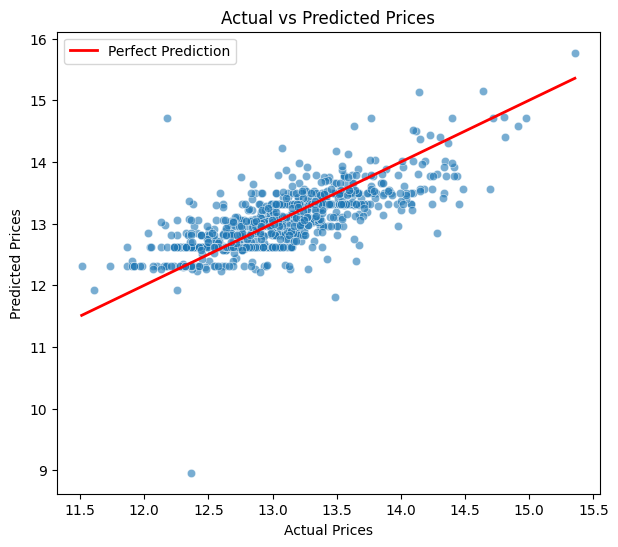

In [18]:
# visualize model performance
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()


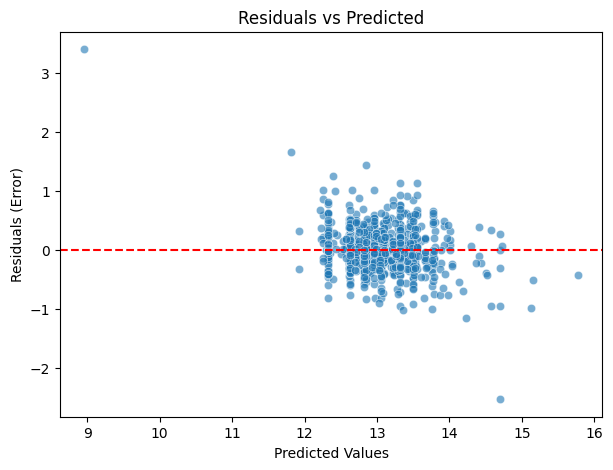

In [19]:
# residual plot
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Error)")
plt.title("Residuals vs Predicted")
plt.show()

In [20]:
# check feature importance (coefficients)
feature_names = ct.get_feature_names_out()
original_features = ['bedrooms','bathrooms','floors', 'waterfront','view', 'condition', 'was_renovated', 'age', 'sqft_lot', 'sqft_living','sqft_basement']
importances = regressor.feature_importances_
n_city_features = len(feature_names) - len(original_features)
coeffs = pd.DataFrame({
    'Feature': original_features,
    'Importance': importances[n_city_features:],
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
coeffs

,Feature,Importance
0,sqft_living,0.601907
1,sqft_lot,0.046798
2,age,0.037173
3,condition,0.022270
4,sqft_basement,0.021689
5,view,0.018409
6,bathrooms,0.013649
7,bedrooms,0.008830
8,floors,0.007199
9,was_renovated,0.001500
